In [ ]:
# Librarias
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# Eliminar notación científica
import numpy as np
np.set_printoptions(suppress = True)
pd.set_option('display.float_format', lambda x: f"{x: 0.5f}")
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt

19:22:30 - cmdstanpy - INFO - Chain [1] start processing
19:22:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


MSE: 0.40
MAE: 0.49
MAPE: 2.98%


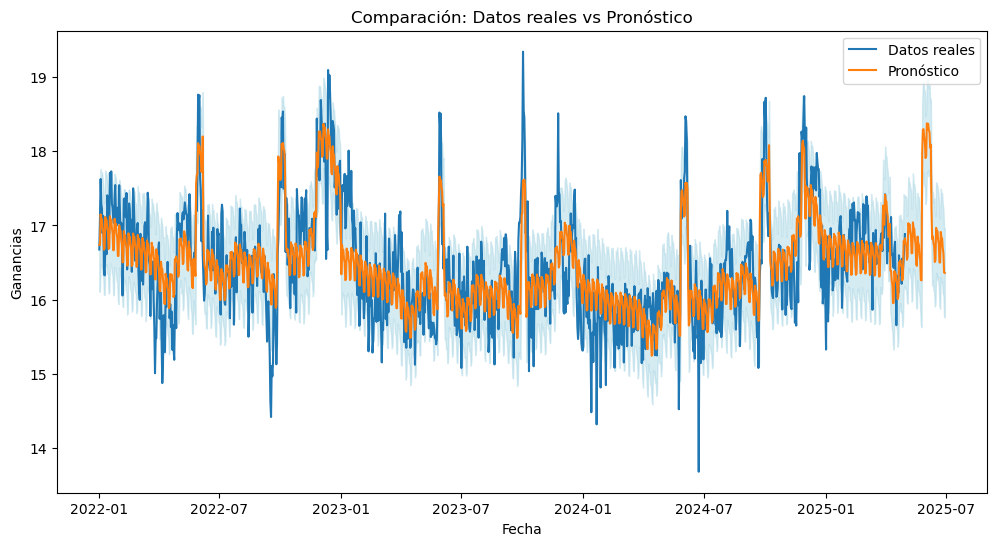

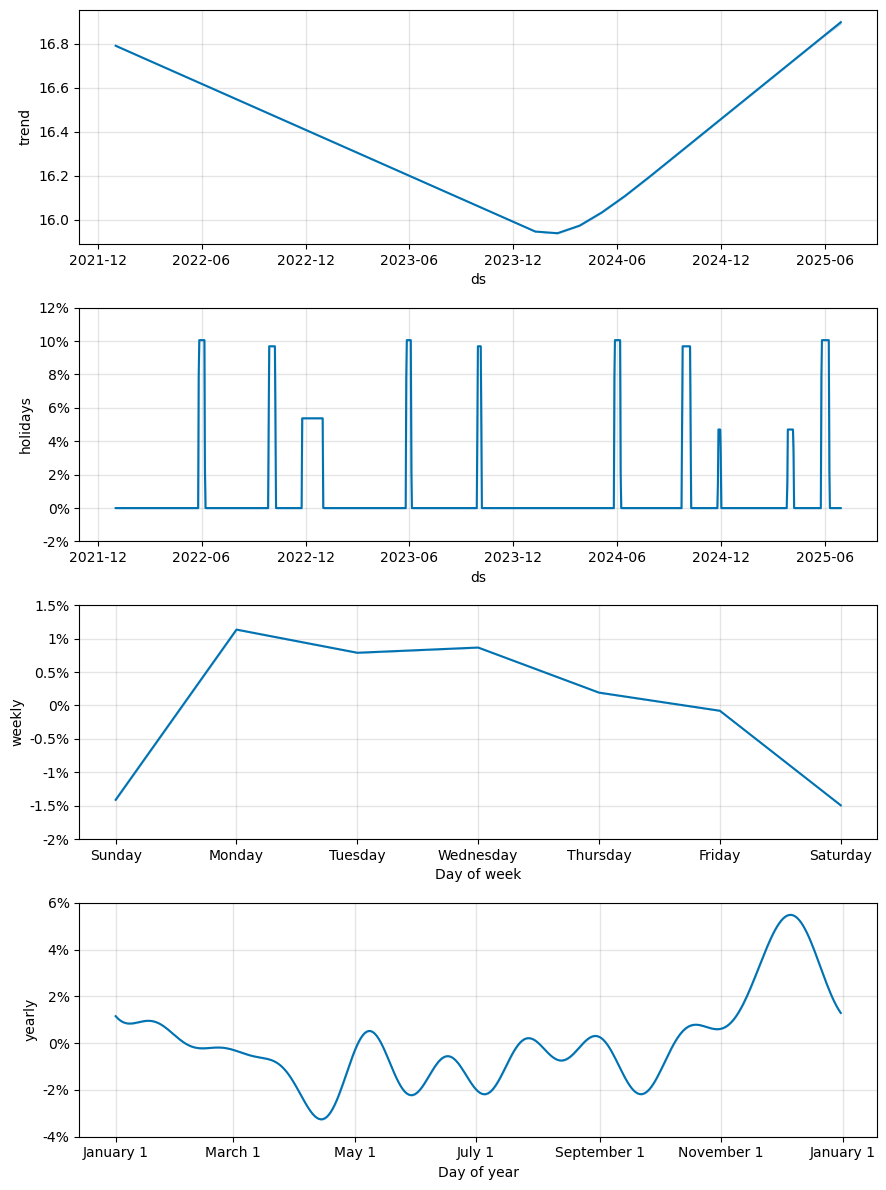

In [ ]:
# Importar datos
df_pagos = pd.read_excel("Curva_entrenamiento.xlsx")

# Procesar ventas
df_pagos['y'].astype(int)
daily_sum = df_pagos.groupby('ds')['y'].sum().reset_index()
# Aplicar transformación logarítmica
daily_sum['y'] = np.log1p(daily_sum['y'])

# Definir eventos especiales
cyber_days_2022_may = pd.date_range(start='2022-05-27', end='2022-06-06')
cyber_days_2022_oct = pd.date_range(start='2022-09-27', end='2022-10-08')
evento_be_2022 = pd.date_range(start='2022-11-25', end='2022-12-31')
cyber_days_2023_may = pd.date_range(start='2023-05-27', end='2023-06-04')
cyber_days_2023_oct = pd.date_range(start='2023-09-29', end='2023-10-05')
cyber_days_2024_may = pd.date_range(start='2024-05-27', end='2024-06-06')
cyber_days_2024_oct = pd.date_range(start='2024-09-23', end='2024-10-07')
black_friday_2024 = pd.date_range(start='2024-11-25', end='2024-11-29')
black_sale_2025_may = pd.date_range(start='2025-03-27', end='2025-04-06')
cyber_days_2025_may = pd.date_range(start='2025-05-26', end='2025-06-08')

# Definir eventos
cyber_days_may = pd.DataFrame({
    'holiday': 'cyber_days_mayo',
    'ds': pd.to_datetime(pd.concat([
        pd.Series(cyber_days_2022_may),
        pd.Series(cyber_days_2023_may),
        pd.Series(cyber_days_2024_may),
        pd.Series(cyber_days_2025_may)
    ])),
    'lower_window': 0,
    'upper_window': 1
})

cyber_days_oct = pd.DataFrame({
    'holiday': 'cyber_days_oct',
    'ds': pd.to_datetime(pd.concat([
        pd.Series(cyber_days_2022_oct),
        pd.Series(cyber_days_2023_oct),
        pd.Series(cyber_days_2024_oct)
    ])),
    'lower_window': 0,
    'upper_window': 1
})

black_sale = pd.DataFrame({
    'holiday': 'black_friday',
    'ds': pd.to_datetime(pd.concat([
        pd.Series(black_friday_2024),
        pd.Series(black_sale_2025_may)
    ])),
    'lower_window': 0,
    'upper_window': 1
})

evento_especial = pd.DataFrame({
    'holiday': 'campaña_especial',
    'ds': pd.to_datetime(evento_be_2022),
    'lower_window': 0,
    'upper_window': 1
})

# Concatenar todos los eventos
holidays_df = pd.concat([
    cyber_days_may,
    cyber_days_oct,
    black_sale,
    evento_especial
])

# Establecer parámetros del mejor modelo
best_params = {
    'changepoint_prior_scale': 0.01,
    'seasonality_prior_scale': 0.01,
    'holidays_prior_scale': 1.0,
    'seasonality_mode': 'multiplicative'
}

# Entrenar el modelo
model = Prophet(
    holidays = holidays_df,
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = False,
    **best_params
)

model.fit(daily_sum)

# Definir el periodo de pronóstico
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

# Revertir transformación logarítmica y exportar pronóstico 
forecast['yhat_real'] = np.expm1(forecast['yhat'])
forecast.to_excel('Prediccion_montos_v2.xlsx', index = False)

# Evaluar con validación cruzada
df_cv = cross_validation(
    model,
    initial='365 days',
    period='30 days',
    horizon='15 days',
    parallel="processes"
)

df_p = performance_metrics(df_cv, rolling_window=1)

print(f"MSE: {np.mean((df_cv['yhat'] - df_cv['y']) ** 2):,.2f}")
print(f"MAE: {np.mean(np.abs(df_cv['yhat'] - df_cv['y'])):,.2f}")
print(f"MAPE: {df_p['mape'].mean()*100:.2f}%")

# Graficar comparación
plt.figure(figsize=(12,6))
plt.plot(daily_sum['ds'], daily_sum['y'], label='Datos reales')
plt.plot(forecast['ds'], forecast['yhat'], label='Pronóstico')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.5)
plt.title('Comparación: Datos reales vs Pronóstico')
plt.xlabel('Fecha')
plt.ylabel('Ganancias')
plt.legend()
plt.show()
model.plot_components(forecast)
plt.show()